# Cyber Security Statistical Inference Pipeline

Using [this](https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset) cyber security dataset on Kaggle, we will be addressing what can lead to a cyber attack using a variety of statistical methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import networkx as nx

## EDA: What can lead to an `Attack`? 💭

### Basic Cleaning

Basic cleaning of dataset and some feature understanding:

In [2]:
df = pd.read_csv("cybersecurity_intrusion_data.csv")
df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [3]:
df.shape

(9537, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


In [5]:
df.describe()

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
count,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000
mean,500.430639,4.032086,792.745312,0.331338,1.517773,0.149942,0.447101
std,198.379364,1.963012,786.560144,0.177175,1.033988,0.357034,0.497220
min,64.000000,1.000000,0.500000,0.002497,0.000000,0.000000,0.000000
25%,365.000000,3.000000,231.953006,0.191946,1.000000,0.000000,0.000000
50%,499.000000,4.000000,556.277457,0.314778,1.000000,0.000000,0.000000
75%,635.000000,5.000000,1105.380602,0.453388,2.000000,0.000000,1.000000
max,1285.000000,13.000000,7190.392213,0.924299,5.000000,1.000000,1.000000


See who is more corrolated with `attack_detected`

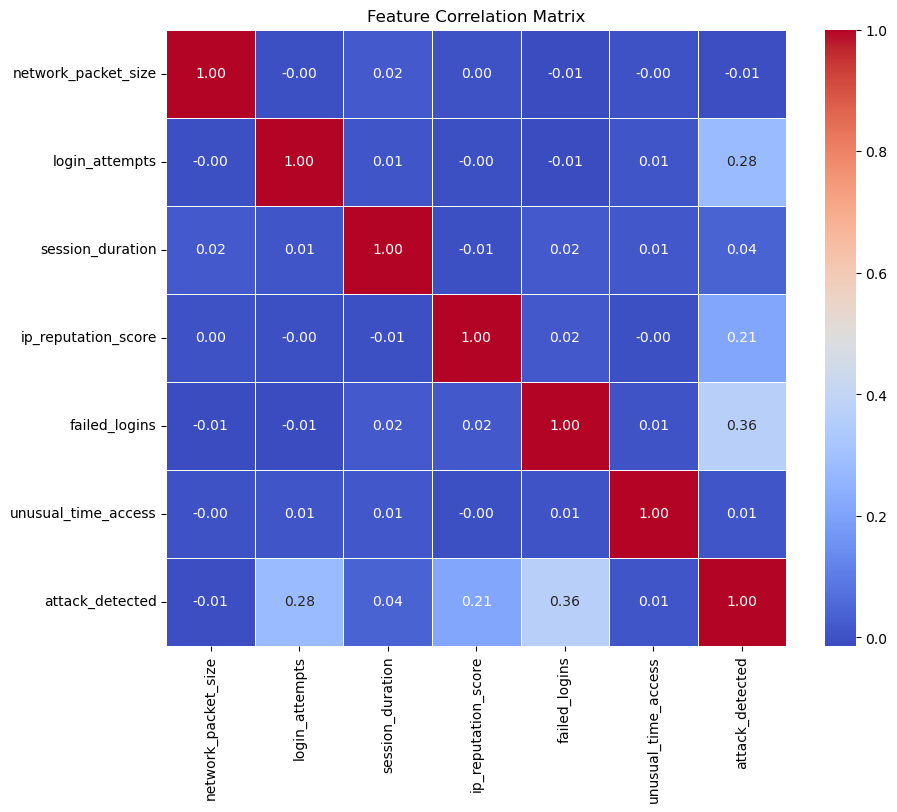

In [6]:
corr_matrix = df.select_dtypes(include='number').corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

### Distributions

Looking at the distributions for attack vs non-attack scenarios

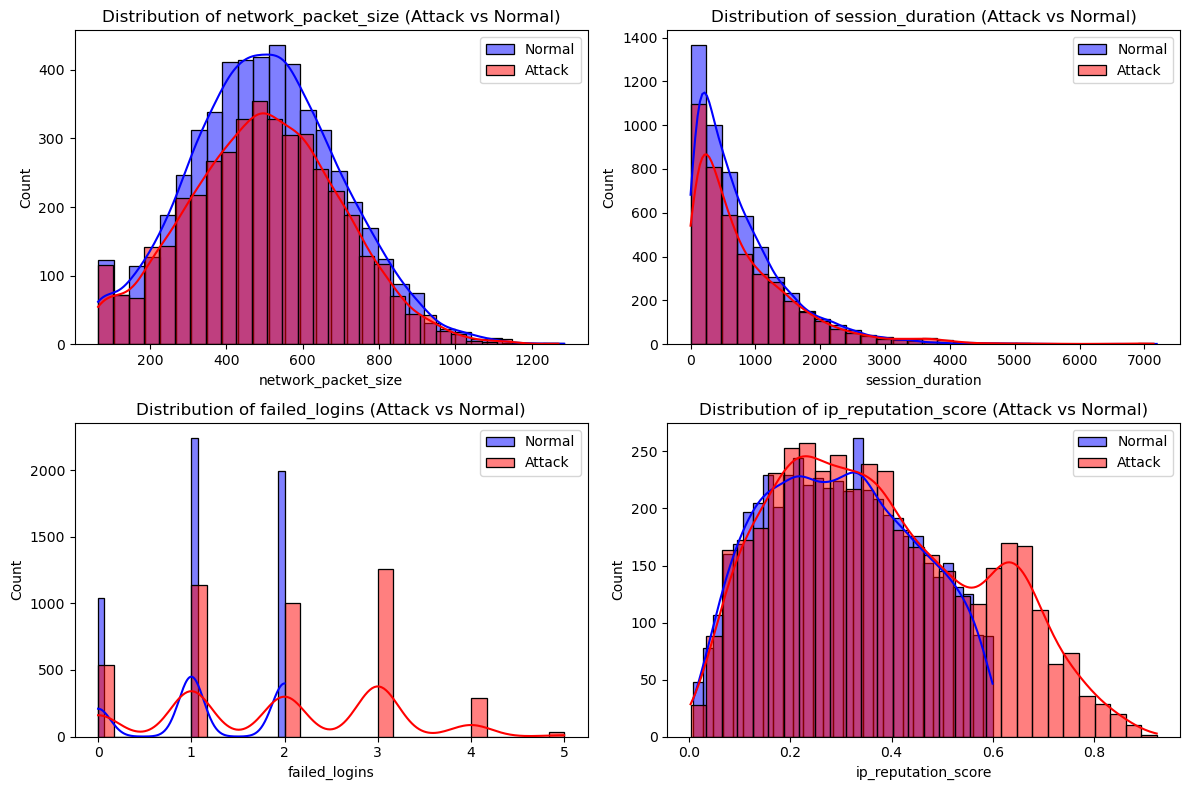

In [7]:
features_to_compare = ['network_packet_size', 'session_duration', 'failed_logins', 'ip_reputation_score']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_compare, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[df['attack_detected'] == 0][feature], label='Normal', kde=True, color='blue', bins=30)
    sns.histplot(df[df['attack_detected'] == 1][feature], label='Attack', kde=True, color='red', bins=30)
    plt.title(f'Distribution of {feature} (Attack vs Normal)')
    plt.legend()

plt.tight_layout()
plt.show()

### Dimension Reduction

Looking at the ELBO PCA curve to decide the number of PCs we want to use

/var/folders/4n/gr221w3n74g83smf7w9pzfy00000gn/T/ipykernel_83409/2013166282.py:10: RuntimeWarning: divide by zero encountered in log
  elbo_curve = np.log(1 - cumulative_variance)


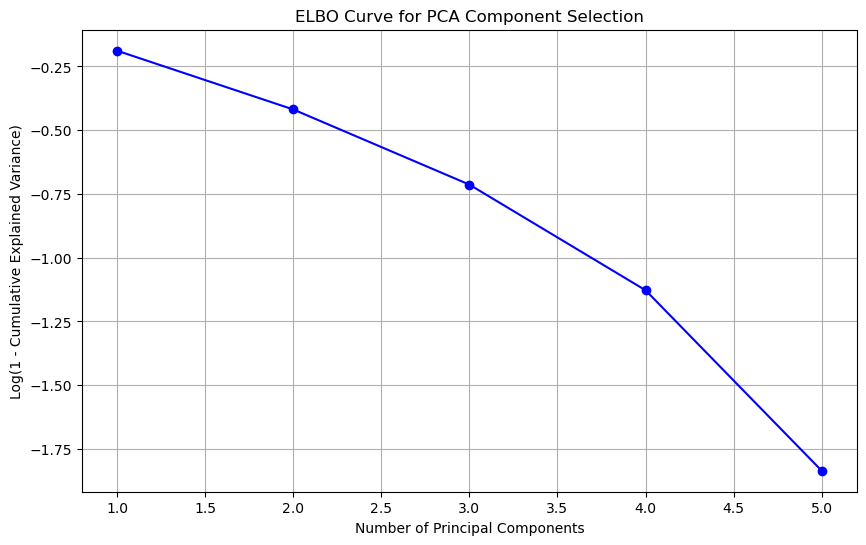

In [8]:
features = df.drop(columns=['attack_detected'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.select_dtypes(include=[np.number]))

pca = PCA()
pca.fit(scaled_features)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
elbo_curve = np.log(1 - cumulative_variance) 

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(elbo_curve) + 1), elbo_curve, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Log(1 - Cumulative Explained Variance)')
plt.title('ELBO Curve for PCA Component Selection')
plt.grid(True)
plt.show()

Conduct PCA to three dimensions

Explained Variance by Component: [0.17155328 0.17050284 0.16800122]
Total Explained Variance: 0.5101


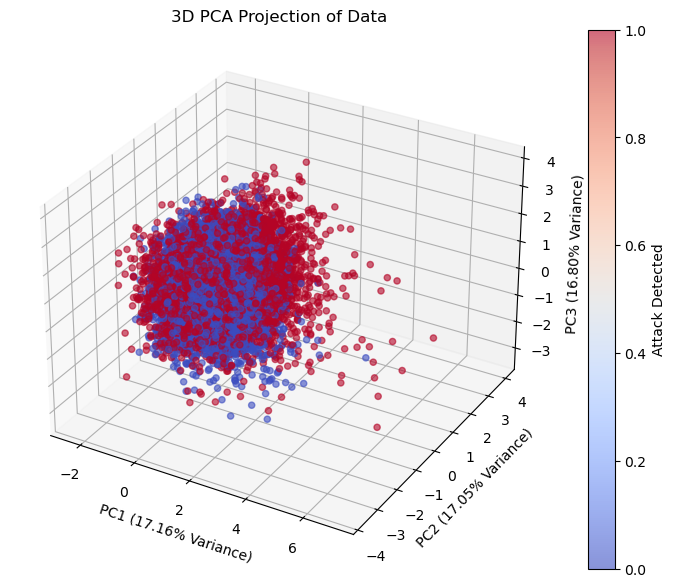

In [9]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_features)

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by Component: {explained_variance}")
print(f"Total Explained Variance: {np.sum(explained_variance):.4f}")

df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])
df_pca['attack_detected'] = df['attack_detected']

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], 
                     c=df_pca['attack_detected'], cmap='coolwarm', alpha=0.6)

ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}% Variance)')
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}% Variance)')
ax.set_zlabel(f'PC3 ({explained_variance[2]*100:.2f}% Variance)')
ax.set_title('3D PCA Projection of Data')

plt.colorbar(scatter, ax=ax, label='Attack Detected')
plt.show()

### Feature Importance

Let's look at some feature importance

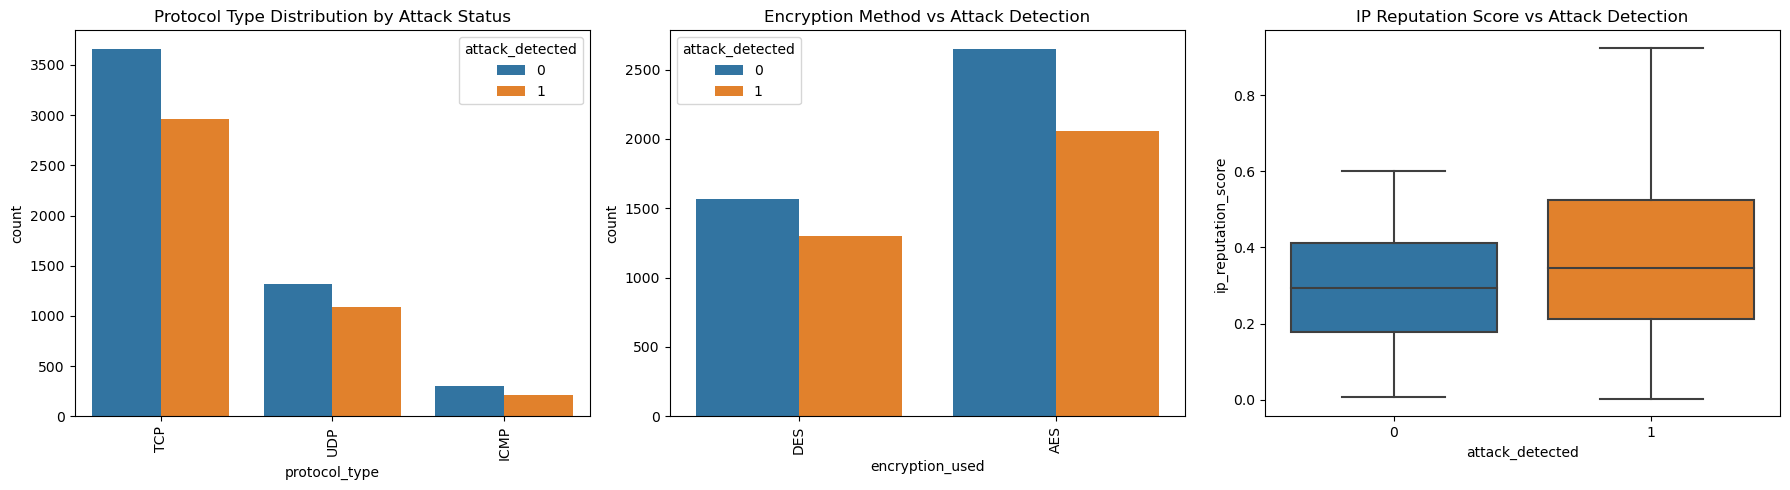

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='protocol_type', hue='attack_detected', data=df, ax=axes[0])
axes[0].set_title('Protocol Type Distribution by Attack Status')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

sns.countplot(x='encryption_used', hue='attack_detected', data=df, ax=axes[1])
axes[1].set_title('Encryption Method vs Attack Detection')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

sns.boxplot(x='attack_detected', y='ip_reputation_score', data=df, ax=axes[2])
axes[2].set_title('IP Reputation Score vs Attack Detection')

plt.tight_layout()
plt.show()

Fit a random forest

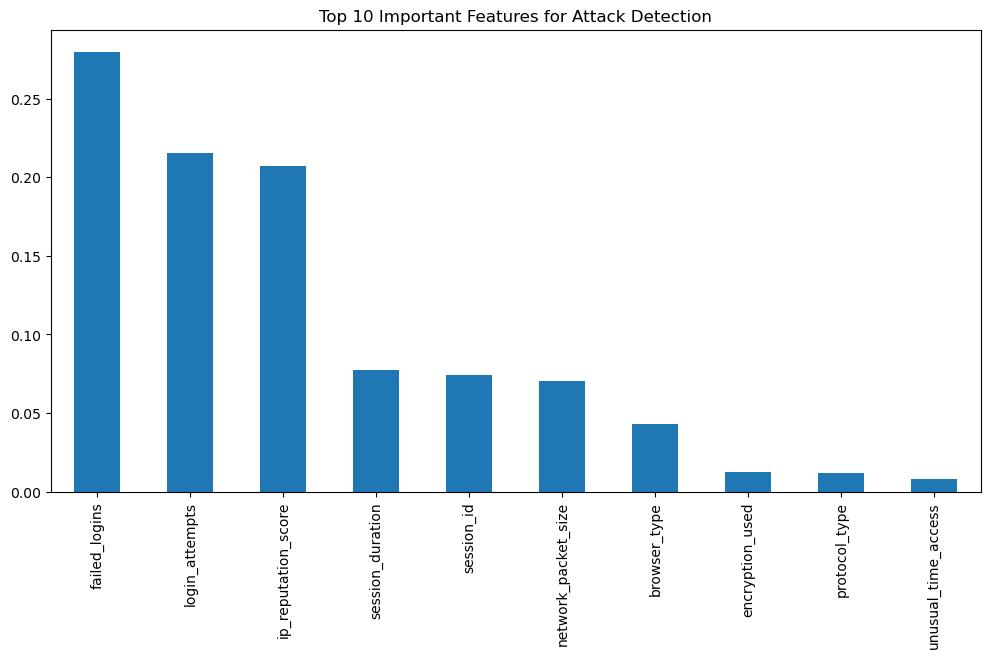

In [11]:
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # encoder for inverse transformation later

X = df.drop(columns=['attack_detected'])
y = df['attack_detected']

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
importances[:10].plot(kind='bar')
plt.title('Top 10 Important Features for Attack Detection')
plt.show()

Feature interaction effects

/Users/leowiemelt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


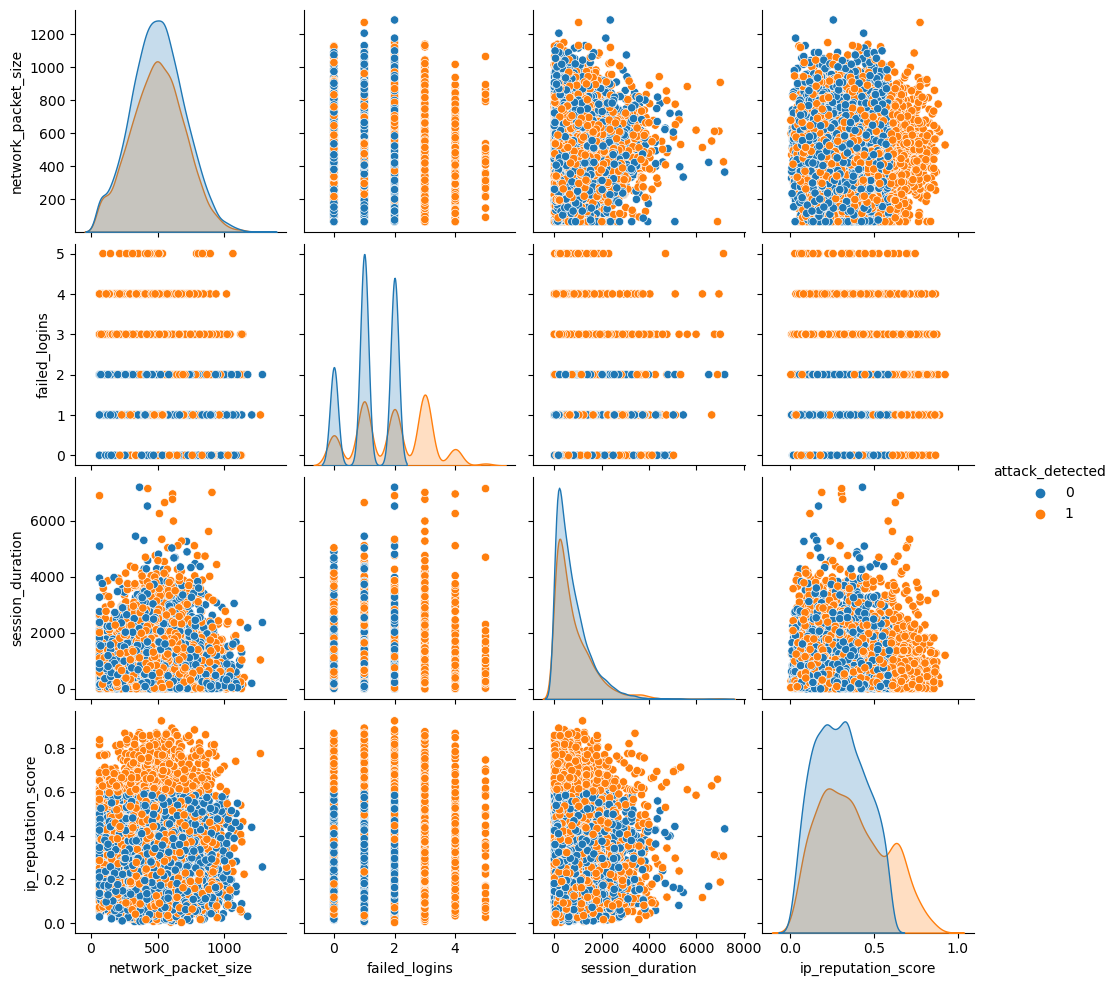

In [12]:
sns.pairplot(df[['network_packet_size', 'failed_logins', 'session_duration', 'ip_reputation_score', 'attack_detected']], hue='attack_detected')
plt.show()

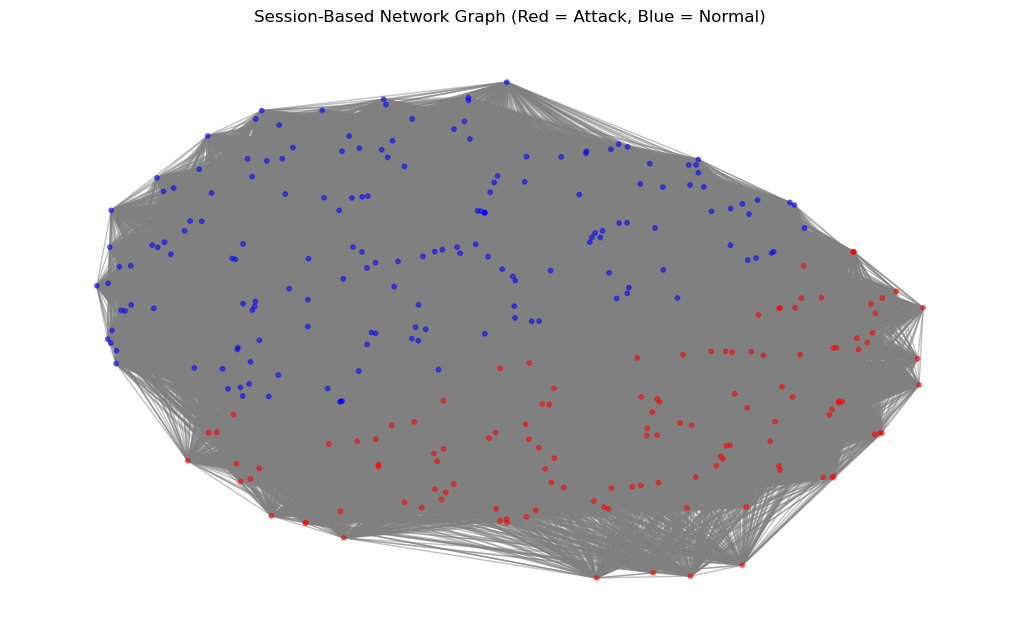

In [13]:
df_sample = df.sample(300)
G = nx.Graph()

# session_id as nodes
for session in df_sample['session_id']:
    G.add_node(session, attack=df_sample[df_sample['session_id'] == session]['attack_detected'].values[0])

# edges based on similarities
for i, row1 in df_sample.iterrows():
    for j, row2 in df_sample.iterrows():
        if i >= j: 
            continue
        
        same_attack_status = row1['attack_detected'] == row2['attack_detected']
        same_protocol = row1['protocol_type'] == row2['protocol_type']
        same_encryption = row1['encryption_used'] == row2['encryption_used']

        # if sessions share attack status, protocol, or encryption, connect them
        if same_attack_status or same_protocol or same_encryption:
            G.add_edge(row1['session_id'], row2['session_id'])

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)

node_colors = ['red' if G.nodes[node]['attack'] == 1 else 'blue' for node in G.nodes]

nx.draw(G, pos, with_labels=False, node_size=10, node_color=node_colors, edge_color='gray', alpha=0.5)
plt.title("Session-Based Network Graph (Red = Attack, Blue = Normal)")
plt.show()

This graph uses each `session_id` as a node and try to construct a graph around each node by looking at smilarity metric based on `attack_detected`, `protocol_type`, and `encryption_used`. This tries to identify connections between each node and see if the three similarity featuires are actually sort of important.

---
---

# Statistical Analysis: What Leads to An Attack?

## Parametric & Non-parametric Hypotheiss Testing 🤔
We can begin with some simple questions from the observations we have made in EDA

> #### Do attack sessions have significantly different session durations compared to normal sessions?
> * We can do Two-sample t-test (if gaussian distribution) or KS-test (if non-gaussian distribution).
> * Hypothesis:
>   * Null (H₀): The mean session duration for attack and normal traffic is the same.
>   * Alternative (H₁): Attack sessions have a different mean session duration.

Let' check the normality of `session_duration` distribution

- We can use the KDE (Kernel Density Estimation) visualization, it creates a smooth curve that approximates the data's underlying distribution.

- If the histogram resembles a bell curve (unimodal & symmetric), it suggests normality.

- However, it does not provide a formal normality test (such as the Shapiro-Wilk test or Kolmogorov-Smirnov test).

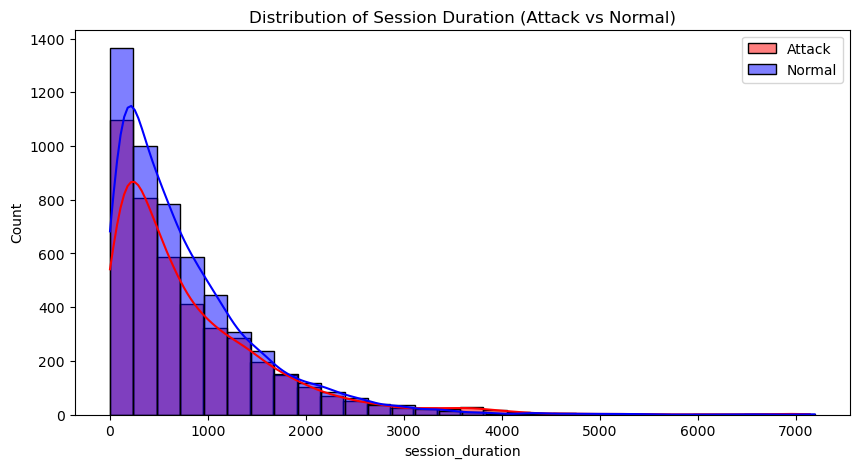

In [14]:
# split data into attack vs normal session durations
attack_sessions = df[df['attack_detected'] == 1]['session_duration']
normal_sessions = df[df['attack_detected'] == 0]['session_duration']

plt.figure(figsize=(10, 5))
sns.histplot(attack_sessions, kde=True, label='Attack', color='red', bins=30)
sns.histplot(normal_sessions, kde=True, label='Normal', color='blue', bins=30)
plt.legend()
plt.title('Distribution of Session Duration (Attack vs Normal)')
plt.show()

More formally, we can scheck normality via `QQ-Plot`, `Shapiro-Wilk Test`, and `Kolmogorov-Smirnov Test`

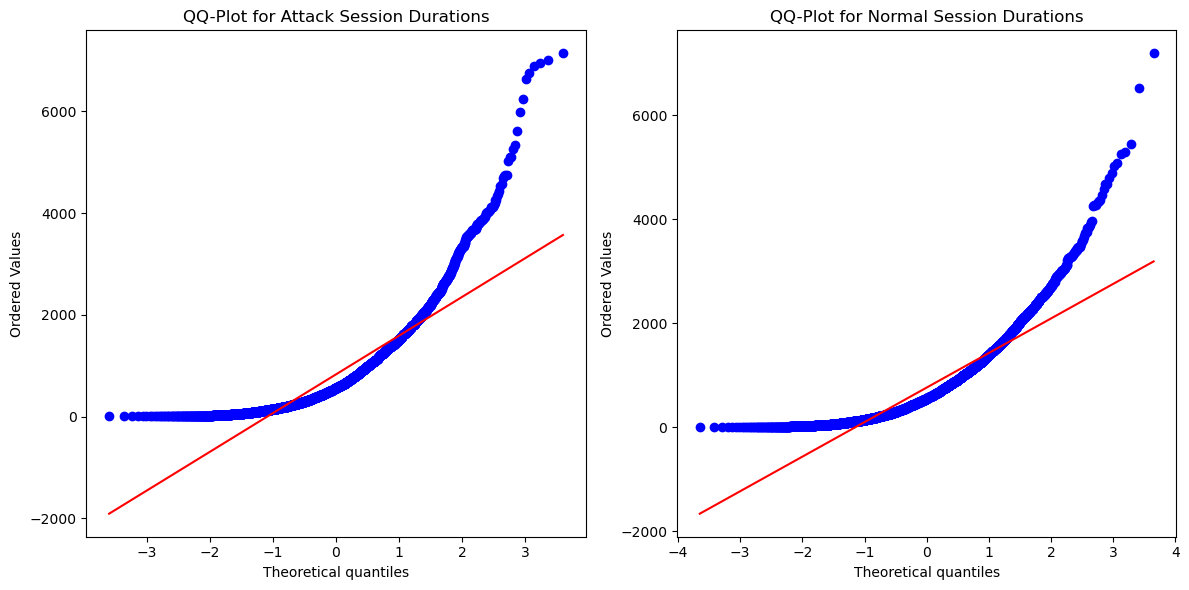

Shapiro-Wilk Test (Attack): W=0.800, p=0.000
Shapiro-Wilk Test (Normal): W=0.835, p=0.000
KS-Test (Attack): Statistic=0.165, p-value=0.000
KS-Test (Normal): Statistic=0.147, p-value=0.000


In [15]:
from scipy.stats import shapiro, kstest, probplot

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
probplot(attack_sessions, dist="norm", plot=axes[0])
axes[0].set_title("QQ-Plot for Attack Session Durations")

probplot(normal_sessions, dist="norm", plot=axes[1])
axes[1].set_title("QQ-Plot for Normal Session Durations")

plt.tight_layout()
plt.show()

shapiro_attack = shapiro(attack_sessions.sample(min(5000, len(attack_sessions))))
shapiro_normal = shapiro(normal_sessions.sample(min(5000, len(normal_sessions))))
print(f"Shapiro-Wilk Test (Attack): W={shapiro_attack[0]:.3f}, p={shapiro_attack[1]:.3f}")
print(f"Shapiro-Wilk Test (Normal): W={shapiro_normal[0]:.3f}, p={shapiro_normal[1]:.3f}")

ks_attack = kstest(attack_sessions, 'norm', args=(attack_sessions.mean(), attack_sessions.std()))
ks_normal = kstest(normal_sessions, 'norm', args=(normal_sessions.mean(), normal_sessions.std()))
print(f"KS-Test (Attack): Statistic={ks_attack.statistic:.3f}, p-value={ks_attack.pvalue:.3f}")
print(f"KS-Test (Normal): Statistic={ks_normal.statistic:.3f}, p-value={ks_normal.pvalue:.3f}")


Seems like the distributions **are not normally distributed**, we will be doing the `KS-test`.

- Good thing with non-parametric hypothesis testing is that we don't need to make any assumption,making it much easier to do hypothesis testing.

In [16]:
from scipy.stats import ttest_ind, ks_2samp

# KS-test (non-parametric)
ks_stat, p_value_ks = ks_2samp(attack_sessions, normal_sessions)
print(f"KS-Test: statistic={ks_stat:.3f}, p-value={p_value_ks:.3f}")

KS-Test: statistic=0.037, p-value=0.003


The `KS-test` passes the alpha value threshold of 0.05, hence **we reject the null hypotehsis that the mean session duration for attack and normal traffic is the same.**

> ### Do attack/no atack follow the same distribution in IP reputation score?
> We can do T-test or KS-test dependening on normality.
> * Hypothesis: 
>   * Null Hypothesis (H₀): The distributions are the same.
>   * Alternative Hypothesis (H₁): Attack sessions follow a different distribution.

Again, we want to check teh normality assumption first

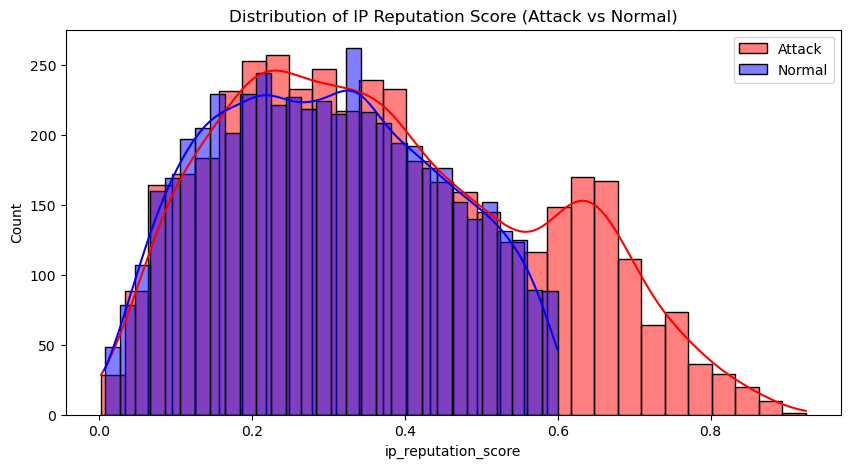

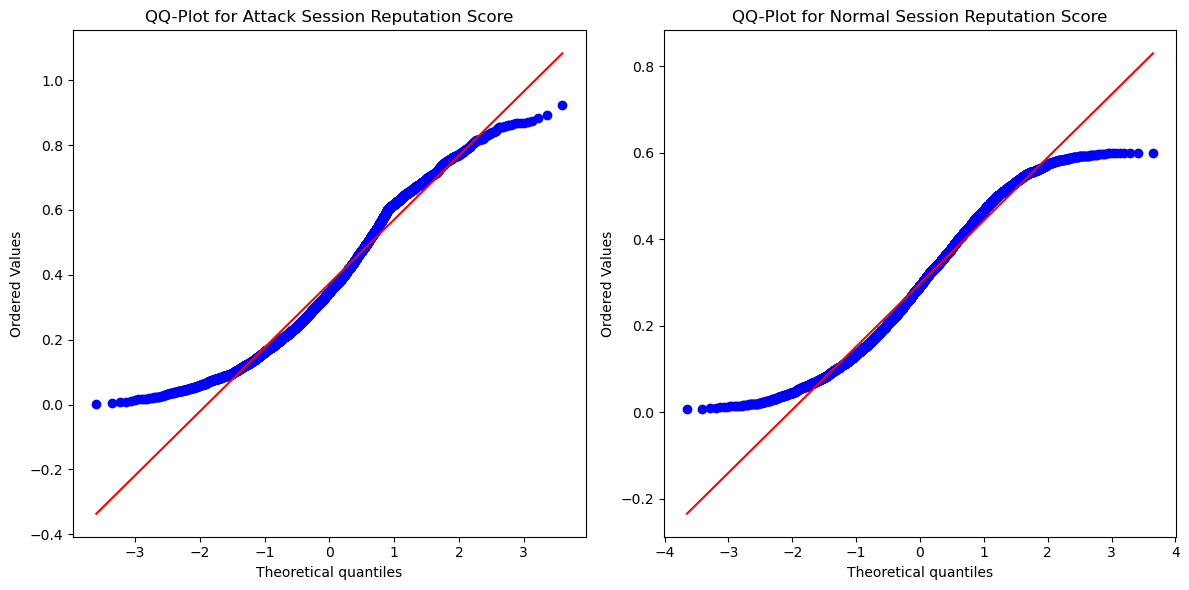

Shapiro-Wilk Test (Attack): W=0.968, p=0.000
Shapiro-Wilk Test (Normal): W=0.975, p=0.000
KS-Test (Attack): Statistic=0.060, p-value=0.000
KS-Test (Normal): Statistic=0.046, p-value=0.000


In [17]:
attack_sessions = df[df['attack_detected'] == 1]['ip_reputation_score']
normal_sessions = df[df['attack_detected'] == 0]['ip_reputation_score']

plt.figure(figsize=(10, 5))
sns.histplot(attack_sessions, kde=True, label='Attack', color='red', bins=30)
sns.histplot(normal_sessions, kde=True, label='Normal', color='blue', bins=30)
plt.legend()
plt.title('Distribution of IP Reputation Score (Attack vs Normal)')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
probplot(attack_sessions, dist="norm", plot=axes[0])
axes[0].set_title("QQ-Plot for Attack Session Reputation Score")

probplot(normal_sessions, dist="norm", plot=axes[1])
axes[1].set_title("QQ-Plot for Normal Session Reputation Score")

plt.tight_layout()
plt.show()

shapiro_attack = shapiro(attack_sessions.sample(min(5000, len(attack_sessions))))
shapiro_normal = shapiro(normal_sessions.sample(min(5000, len(normal_sessions))))
print(f"Shapiro-Wilk Test (Attack): W={shapiro_attack[0]:.3f}, p={shapiro_attack[1]:.3f}")
print(f"Shapiro-Wilk Test (Normal): W={shapiro_normal[0]:.3f}, p={shapiro_normal[1]:.3f}")

ks_attack = kstest(attack_sessions, 'norm', args=(attack_sessions.mean(), attack_sessions.std()))
ks_normal = kstest(normal_sessions, 'norm', args=(normal_sessions.mean(), normal_sessions.std()))
print(f"KS-Test (Attack): Statistic={ks_attack.statistic:.3f}, p-value={ks_attack.pvalue:.3f}")
print(f"KS-Test (Normal): Statistic={ks_normal.statistic:.3f}, p-value={ks_normal.pvalue:.3f}")

Seems to be much more normally distributed comparing to `session_duration`

In [18]:
attack_sessions = df[df['attack_detected'] == 1]['ip_reputation_score']
normal_sessions = df[df['attack_detected'] == 0]['ip_reputation_score']

t_stat, p_value_ttest = ttest_ind(attack_sessions, normal_sessions, equal_var=False)
print(f"T-test: t-statistic={t_stat:.3f}, p-value={p_value_ttest:.3f}")

T-test: t-statistic=20.478, p-value=0.000


The `T-test` passes the alpha value threshold of 0.05, hence **we reject the null hypotehsis that the ip reputation score for attack and normal traffic is the same.**

> ### Are attack sessions randomly distributed throughout the dataset?
> We can do Wald-Wolfowitz Runs Test for randomness
> * Hypothesis:
>   * Null Hypothesis (H₀): Attack sessions are randomly distributed.
>   * Alternative Hypothesis (H₁): Attack sessions follow a pattern.

In [19]:
from statsmodels.sandbox.stats.runs import runstest_1samp

runs_p_value = runstest_1samp(df['attack_detected'])
print(f"Wald-Wolfowitz Runs Test p-value: {runs_p_value}")

Wald-Wolfowitz Runs Test p-value: (-0.06472029385685857, 0.9483967045352081)


How about some **ordinal test** for some of the ordinal columns we have, such as `failed_login_attempts`

> ### Do attack sessions have significantly different failed login attempts compared to normal sessions?
> * We can do the **Mann-Whitney U Test** (Wilcoxon Rank-Sum Test) as we want a non-parametric test for comparing ordinal data distributions between two independent groups.
> * Hypothesis:
>   * H₀: Attack and normal sessions have the same median failed logins.
>   * H₁: Attack and normal sessions differ in failed logins.

Again, we can check underlaying distribution

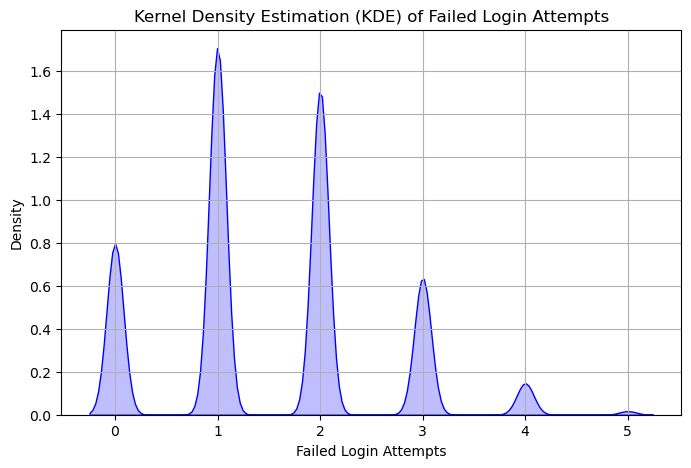

In [20]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df['failed_logins'], fill=True, bw_adjust=0.5, color='blue')
plt.title('Kernel Density Estimation (KDE) of Failed Login Attempts')
plt.xlabel('Failed Login Attempts')
plt.ylabel('Density')
plt.grid(True)
plt.show()

Of course, normallity assumption does not hold and we need to do **non-parametric testing**.

In [21]:
from scipy.stats import mannwhitneyu

attack_failed_logins = df[df['attack_detected'] == 1]['failed_logins']
normal_failed_logins = df[df['attack_detected'] == 0]['failed_logins']

mw_stat, mw_p = mannwhitneyu(attack_failed_logins, normal_failed_logins, alternative="two-sided")
print(f"Mann-Whitney U Test: Statistic={mw_stat:.3f}, p-value={mw_p:.3f}")

Mann-Whitney U Test: Statistic=15391006.500, p-value=0.000


The `Mann-Whitney U Test` passes the alpha value threshold of 0.05, hence **we reject the null hypotehsis that the failed login attempts for attack and normal traffic is the same.**

Seems like we have found many **covariate** that effects the responses greatly can we have a more systematic way of doing so?

---

## Regression Analysis 🚀

Since `attack_detected` is a **binary response variable** (0 = normal, 1 = attack), logistic regression is the ideal statistical method for modeling attack detection probabilities.

*We will be using both packages coming from `sklearn` and `smf` since they serve good purpos at different part of the analysis.

In [22]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import scipy.stats as stats

### Baseline Logistic Regression

Let's fit a baseline logistic regression model frst to examine the effects of each of the covariates. Notice that we will be using `smf.logit` here. Notice that we introduced one hot encoding in earlier sections for later models to wor better, but for baseline model, we want to interpret all of the coefficients, so we will maintain the original data typ (i.e categorical) and use `smf.logit` to fit.

In [23]:
df_base = pd.read_csv("cybersecurity_intrusion_data.csv")
to_category_columns = ['protocol_type', 'encryption_used', 'browser_type']
df_base[to_category_columns] = df_base[to_category_columns].astype('category')
X = df_base.drop(columns=['attack_detected', 'session_id'])
formula = 'attack_detected ~ ' + (" + ".join(list(X.columns)))
logit_model = smf.logit(formula, data=df_base).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.522899
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        attack_detected   No. Observations:                 7571
Model:                          Logit   Df Residuals:                     7557
Method:                           MLE   Df Model:                           13
Date:                Sat, 14 Jun 2025   Pseudo R-squ.:                  0.2385
Time:                        23:09:40   Log-Likelihood:                -3958.9
converged:                       True   LL-Null:                       -5198.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -4.8112      0.185    -25.949      0.000      -5.175   

In [24]:
odds_ratios = np.exp(logit_model.params)
print("\nOdds Ratios:\n", odds_ratios)


Odds Ratios:
 Intercept                   0.008138
protocol_type[T.TCP]        1.123734
protocol_type[T.UDP]        1.066381
encryption_used[T.DES]      1.119776
browser_type[T.Edge]        1.017994
browser_type[T.Firefox]     0.997882
browser_type[T.Safari]      1.006491
browser_type[T.Unknown]     6.260080
network_packet_size         0.999916
login_attempts              1.501577
session_duration            1.000127
ip_reputation_score        27.048058
failed_logins               2.681841
unusual_time_access         1.003044
dtype: float64


### ANOVA 🤔 ➡️ ❌
We want to start with **Analysis of Variance**, seeing if adding extra variables actually improves the explanability of the varaince. However, we cannot do so as ANOVA is made for linear regressions and assumption need to be held for linear regression cases instead of the logistic function that we are using. But maybe we can use alternative methods to test the importance of covariates, namely **forward/backward selection** + **shrinking method with cross validation**.

### Forward/Backward Stepwise Selection

We uses the Akaike Information Criterion (AIC) to meausure the **goodness of fit** of a model, adjusted for the number of predictors. They are both based on the log-likelihood of the model and the number of predictors. Remember the log-likelihood of the model is given by

$$
\ell(\beta) = \sum_{i=1}^{n} \log f(y_i | x_i, \beta)
$$

The **AIC** is defined as

$$
AIC = -2\ell(\beta) + 2p
$$

The key idea is that:
- AIC tells you given the previous predictor, how much the new one explains the variance.
- Smaller AIC resembles better model fit.

In [25]:
# forward selection based on AIC
def forward_selection(data, target, predictors):
    selected_predictors = []
    remaining_predictors = list(predictors)
    best_aic = float("inf")
    
    while remaining_predictors:
        best_candidate = None
        for predictor in remaining_predictors:
            formula = f"{target} ~ {' + '.join(selected_predictors + [predictor])}"
            model = smf.logit(formula, data=data).fit(disp=0)
            if model.aic < best_aic:
                best_aic = model.aic
                best_candidate = predictor
        
        if best_candidate:
            remaining_predictors.remove(best_candidate)
            selected_predictors.append(best_candidate)
        else:
            break
            
    return selected_predictors

# backward elimination based on AIC
def backward_elimination(data, target, predictors):
    selected_predictors = list(predictors)
    best_aic = float("inf")
    
    while len(selected_predictors) > 1:
        worst_candidate = None
        for predictor in selected_predictors:
            reduced_predictors = selected_predictors.copy()
            reduced_predictors.remove(predictor)
            formula = f"{target} ~ {' + '.join(reduced_predictors)}"
            model = smf.logit(formula, data=data).fit(disp=0)
            if model.aic < best_aic:
                best_aic = model.aic
                worst_candidate = predictor
        
        if worst_candidate:
            selected_predictors.remove(worst_candidate)
        else:
            break
            
    return selected_predictors

In [26]:
covariates = df.drop(columns=['attack_detected']).columns

selected_features_forward = forward_selection(df, 'attack_detected', covariates)
print("Selected Features (Forward Selection):", selected_features_forward)

selected_features_backward = backward_elimination(df, 'attack_detected', covariates)
print("Selected Features (Backward Elimination):", selected_features_backward)

Selected Features (Forward Selection): ['failed_logins', 'login_attempts', 'ip_reputation_score', 'browser_type', 'session_duration', 'encryption_used']
Selected Features (Backward Elimination): ['login_attempts', 'session_duration', 'encryption_used', 'ip_reputation_score', 'failed_logins', 'browser_type']


Seems like the **forward** and **backward** method does find different fearures that effect AIC, but they seem to be similar at least.

We will do similar things by using **shrinking method in the below section**, which wil be the actual final feature selection that we give into our final logistic model.

### Shrinking Method

Notice in this section we use `sklearn` here because they are better to work with when trying to do regularziations than `smf.logit` as well as that they seem to be a bit faster to run, which is good since we are doing grid search cv.

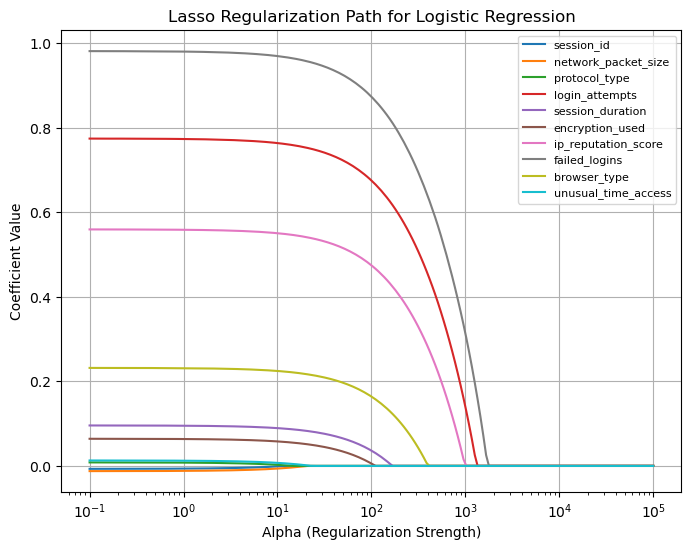

In [27]:
X = df.drop(columns=['attack_detected']) 
y = df['attack_detected'] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
alphas = np.logspace(-1, 5, 200)  # log-spaced values for better resolution

lasso_coefs = []
for alpha in alphas:
    lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1/alpha, max_iter=500)
    lasso.fit(X_scaled, y)
    lasso_coefs.append(lasso.coef_[0])

lasso_coefs = pd.DataFrame(lasso_coefs, index=alphas, columns=df.drop(columns=['attack_detected']).columns)

fig, ax = plt.subplots(figsize=(8, 6))
for column in lasso_coefs.columns:
    ax.plot(alphas, lasso_coefs[column], label=column)

ax.set_xscale('log')
ax.set_xlabel('Alpha (Regularization Strength)')
ax.set_ylabel('Coefficient Value')
ax.set_title('Lasso Regularization Path for Logistic Regression')
ax.legend(loc='best', fontsize=8, frameon=True)
ax.grid(True)
plt.show()

Remanber that from the previous forward/backward selection,we have the following features:

- Forward Selection: `failed_logins`, `login_attempts`, `ip_reputation_score`, `browser_type`, `session_duration`, and `encryption_used`.

- Backward Elimination: `login_attempts`, `session_duration`, `encryption_used`, `ip_reputation_score`, `failed_logins`, and `browser_type`.

From the shrinking method, seems like `failed_logins`, `login_attempts`, `ip_reputation_score`, `browser_type`,`session_duration`, and `encryption_used` seems  to be coefficient that are relatively more important. Note that this is consistent with the forward selction model, which we will be using in our final logistic model.

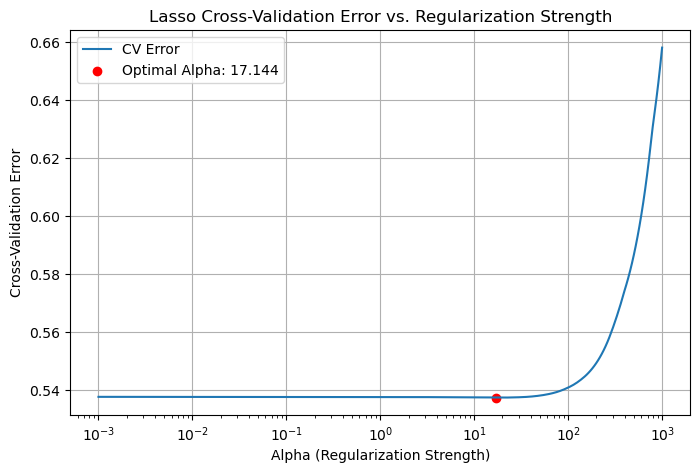

Optimal alpha: 17.14406135851972, CV Error: 0.5375163171373579


In [28]:
# alpha values
alphas = np.logspace(-3, 3, 300) 
cv_errors = np.zeros_like(alphas)

for i, alpha in enumerate(alphas):
    lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1/alpha, max_iter=500)
    cv_scores = cross_val_score(lasso, X_scaled, y, cv=5, scoring='neg_log_loss')  # Log loss as error metric
    cv_errors[i] = -np.mean(cv_scores)

plt.figure(figsize=(8, 5))
plt.plot(alphas, cv_errors, label="CV Error")
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Cross-Validation Error')
plt.title('Lasso Cross-Validation Error vs. Regularization Strength')

optimal_alpha_idx = np.argmin(cv_errors)
optimal_alpha = alphas[optimal_alpha_idx]
plt.scatter(optimal_alpha, cv_errors[optimal_alpha_idx], color='red', label=f'Optimal Alpha: {optimal_alpha:.3f}')

plt.legend()
plt.grid(True)
plt.show()

print(f'Optimal alpha: {optimal_alpha}, CV Error: {cv_errors[optimal_alpha_idx]}')

### Interpretating Coefficients


Final Selected Important Features & Coefficients:
network_packet_size   -0.001994
login_attempts         0.756619
session_duration       0.085003
encryption_used        0.053568
ip_reputation_score    0.544343
failed_logins          0.961737
browser_type           0.219567
unusual_time_access    0.003251
dtype: float64


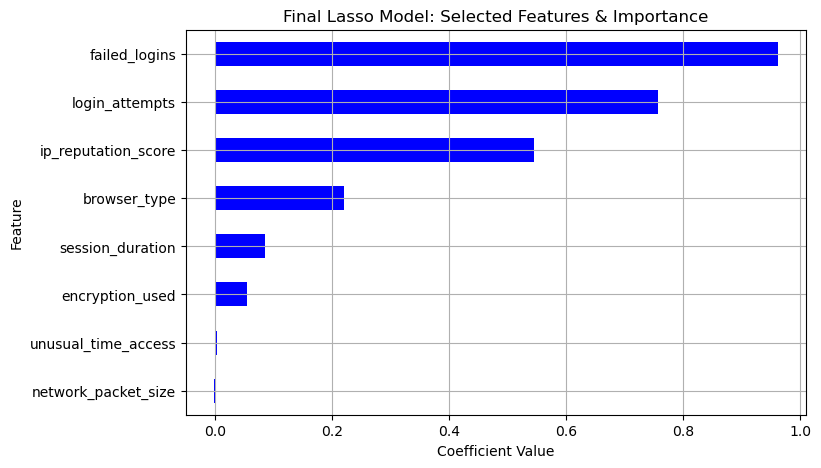

In [29]:
final_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1/optimal_alpha, max_iter=500)
final_lasso.fit(X_scaled, y)

final_coefs = pd.Series(final_lasso.coef_[0], index=df.drop(columns=['attack_detected']).columns)

print("\nFinal Selected Important Features & Coefficients:")
print(final_coefs[final_coefs != 0])

plt.figure(figsize=(8, 5))
final_coefs[final_coefs != 0].sort_values().plot(kind='barh', color='blue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Final Lasso Model: Selected Features & Importance')
plt.grid(True)
plt.show()

### Interaction Models

Again, we choose to use `smf.logit` here, which is different from previous section where we uses `sklearn`, this is because that `smf.logit` is simply easier to work with interaction terms comparing to `sklearn`.

<Figure size 800x600 with 0 Axes>

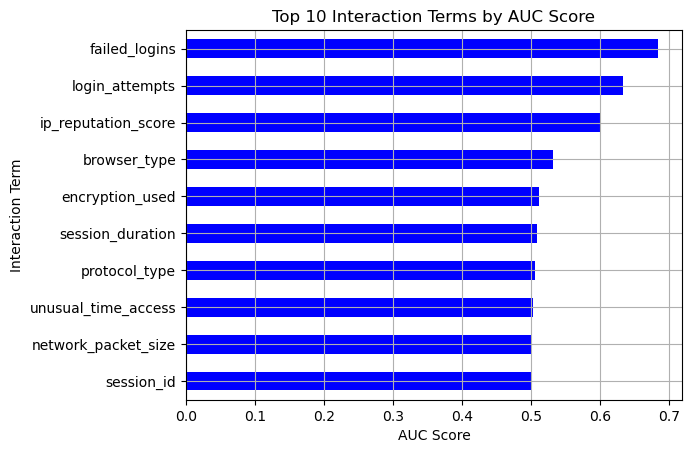

In [30]:
numeric_features = df.select_dtypes(include=['number']).columns.tolist()
if 'attack_detected' in numeric_features:
    numeric_features.remove('attack_detected')
    
interaction_results = {}

for feature in numeric_features:
    formula = f"attack_detected ~ {feature}"

    interaction_model = smf.logit(formula, data=df).fit(disp=0) 
    
    y_scores = interaction_model.predict(df)
    fpr, tpr, _ = roc_curve(df['attack_detected'], y_scores)
    roc_auc = auc(fpr, tpr)

    interaction_results[feature] = roc_auc

interaction_results_df = pd.DataFrame.from_dict(interaction_results, orient='index', columns=['AUC Score'])
interaction_results_df = interaction_results_df.sort_values(by='AUC Score', ascending=False)

plt.figure(figsize=(8, 6))
interaction_results_df.head(10).sort_values(by='AUC Score').plot(kind='barh', legend=False, color='blue')
plt.xlabel('AUC Score')
plt.ylabel('Interaction Term')
plt.title('Top 10 Interaction Terms by AUC Score')
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

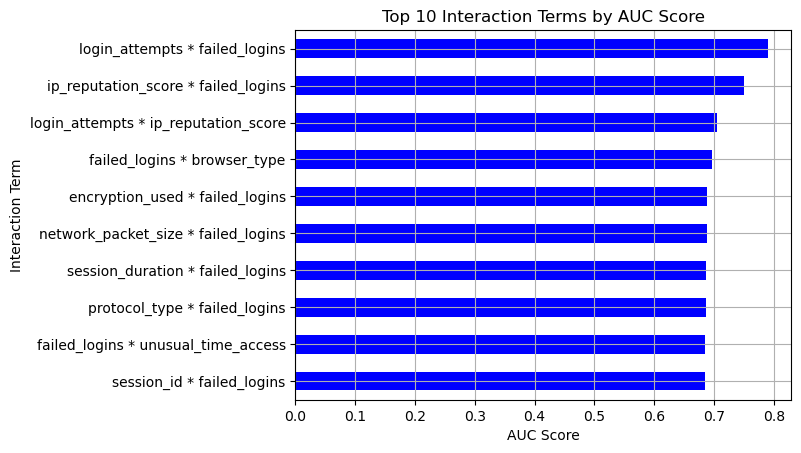

In [31]:
from itertools import combinations

numeric_features = df.select_dtypes(include=['number']).columns.tolist()
if 'attack_detected' in numeric_features:
    numeric_features.remove('attack_detected')
    
interaction_results = {}

for feature1, feature2 in combinations(numeric_features, 2):
    interaction_term = f"{feature1} * {feature2}"
    formula = f"attack_detected ~ {interaction_term}"

    interaction_model = smf.logit(formula, data=df).fit(disp=0) 
    
    y_scores = interaction_model.predict(df)
    fpr, tpr, _ = roc_curve(df['attack_detected'], y_scores)
    roc_auc = auc(fpr, tpr)

    interaction_results[interaction_term] = roc_auc

interaction_results_df = pd.DataFrame.from_dict(interaction_results, orient='index', columns=['AUC Score'])
interaction_results_df = interaction_results_df.sort_values(by='AUC Score', ascending=False)

plt.figure(figsize=(8, 6))
interaction_results_df.head(10).sort_values(by='AUC Score').plot(kind='barh', legend=False, color='blue')
plt.xlabel('AUC Score')
plt.ylabel('Interaction Term')
plt.title('Top 10 Interaction Terms by AUC Score')
plt.grid(True)
plt.show()

We can then fit the model again with this interaction model (note that the AUC score will change for the true model from the one observed above as the above only uses one covaraite to fit the logistic regression).


Final Selected Important Features & Coefficients:
login_attempts                          1.548828
session_duration                        0.087226
encryption_used                         0.056479
ip_reputation_score                     1.165784
failed_logins                           2.058754
browser_type                            0.279318
login_attempts * failed_logins         -0.892102
ip_reputation_score * failed_logins    -0.499429
login_attempts * ip_reputation_score   -0.452957
failed_logins * browser_type           -0.071078
dtype: float64


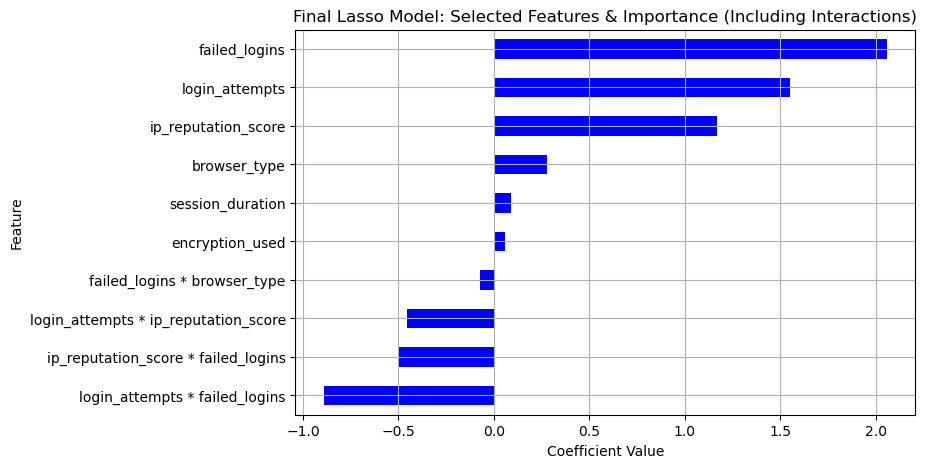

In [32]:
top_interaction_terms = [
    ('login_attempts', 'failed_logins'),
    ('ip_reputation_score', 'failed_logins'),
    ('login_attempts', 'ip_reputation_score'),
    ('failed_logins', 'browser_type'),
    ('encryption_used', 'failed_logins'),
    ('network_packet_size', 'failed_logins'),
    ('session_duration', 'failed_logins'),
    ('protocol_type', 'failed_logins'),
    ('failed_logins', 'unusual_time_access'),
    ('session_id', 'failed_logins')
]

for feature1, feature2 in top_interaction_terms:
    interaction_feature = f"{feature1} * {feature2}"
    df[interaction_feature] = df[feature1] * df[feature2]

X_interact = df.drop(columns=['attack_detected'])
y = df['attack_detected']

scaler = StandardScaler()
X_scaled_interact = scaler.fit_transform(X_interact)

final_lasso_interact = LogisticRegression(penalty='l1', solver='liblinear', C=1/optimal_alpha, max_iter=500)
final_lasso_interact.fit(X_scaled_interact, y)
final_coefs = pd.Series(final_lasso_interact.coef_[0], index=X_interact.columns)

print("\nFinal Selected Important Features & Coefficients:")
important_features = final_coefs[abs(final_coefs) >= 0.05]
print(important_features)

plt.figure(figsize=(8, 5))
important_features.sort_values().plot(kind='barh', color='blue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Final Lasso Model: Selected Features & Importance (Including Interactions)')
plt.grid(True)
plt.show()

### Principal Components Logistic Regression

Since we use interaction term, we will see that `VIF` (Variance Inflation Factor) may have extremely high values, which is insufficient for us to interpret the coefficient and fitting the model. We can fit a **Principal Component Regression**, though this will also make the coefficients uninterpretable, we can have a model that is not consisting of multicollinear covaraites.

In [33]:
X = df.drop(columns=['attack_detected'])
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                 Feature        VIF
0                             session_id  11.408964
1                    network_packet_size  18.799792
2                          protocol_type  17.288883
3                         login_attempts  25.006658
4                       session_duration   6.093939
5                        encryption_used   5.612901
6                    ip_reputation_score  25.197373
7                          failed_logins  33.007237
8                           browser_type   4.973109
9                    unusual_time_access   3.653609
10        login_attempts * failed_logins  14.568095
11   ip_reputation_score * failed_logins  13.268623
12  login_attempts * ip_reputation_score  20.741773
13          failed_logins * browser_type   5.013674
14       encryption_used * failed_logins   5.642555
15   network_packet_size * failed_logins  19.818601
16      session_duration * failed_logins   5.864106
17         protocol_type * failed_logins  18.556875
18   failed_

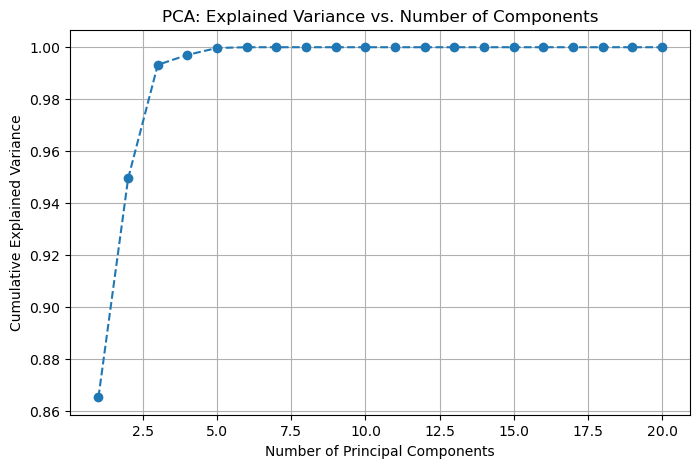

Optimal Number of Components: 3
Cross-Validation Accuracy: 0.716


In [34]:
scaler = StandardScaler()
X_scaled_pca = scaler.fit_transform(df.drop(columns=['attack_detected']))
y = df['attack_detected']

pca = PCA()
X_pca = pca.fit_transform(X_interact)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

# choose number of components to capture ~95% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1

pca = PCA(n_components=n_components)
logistic_pca = Pipeline([('pca', pca), ('logistic', LogisticRegression(penalty='l1', solver='liblinear', max_iter=500))])

cv_scores = cross_val_score(logistic_pca, X_scaled_pca, y, cv=5, scoring='accuracy')

logistic_pca.fit(X_scaled_pca, y)

print(f"Optimal Number of Components: {n_components}")
print(f"Cross-Validation Accuracy: {cv_scores.mean():.3f}")

In [35]:
X_pca_optimal = pca.fit_transform(X_scaled_pca)
logistic_pca_optimal = Pipeline([('pca', pca), ('logistic', LogisticRegression(penalty='l1', solver='liblinear', max_iter=500))])
logistic_pca_optimal.fit(X_pca_optimal, y)

pca_df = pd.DataFrame(X_pca_optimal, columns=[f'PC{i+1}' for i in range(n_components)])
vif_data = pd.DataFrame()
vif_data['Feature'] = pca_df.columns
vif_data['VIF'] = [variance_inflation_factor(X_pca_optimal, i) for i in range(n_components)]

print(vif_data)

  Feature  VIF
0     PC1  1.0
1     PC2  1.0
2     PC3  1.0


### Fit of Model
We will be examining fit of model via a **ROC + AUC** metric.

#### Basic Lasso Logistic Regression

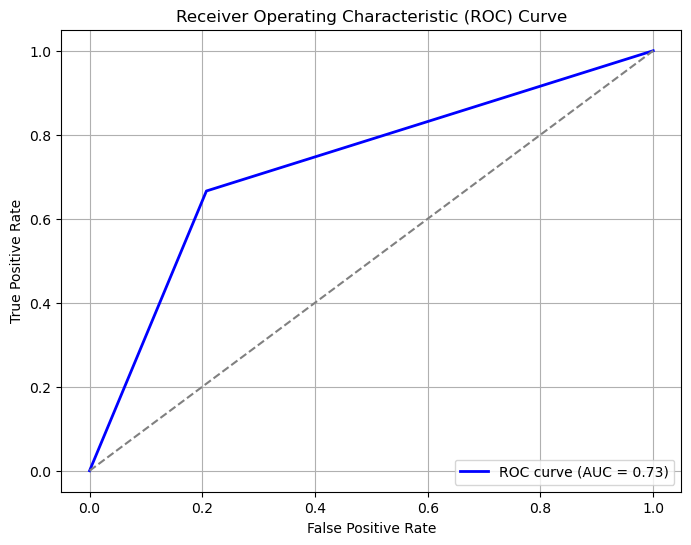

Model AUC: 0.729


In [36]:
pred = final_lasso.predict(X_scaled)
fpr, tpr, _ = roc_curve(y, pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Model AUC: {roc_auc:.3f}")

#### Lasso Interaction Logistic Regression

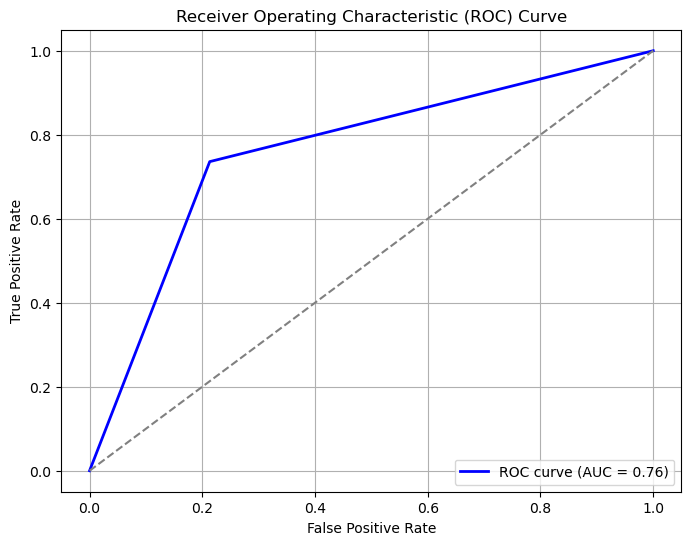

Model AUC: 0.761


In [37]:
pred = final_lasso_interact.predict(X_scaled_interact)
fpr, tpr, _ = roc_curve(y, pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Model AUC: {roc_auc:.3f}")

#### Principla Components Logistic Regression

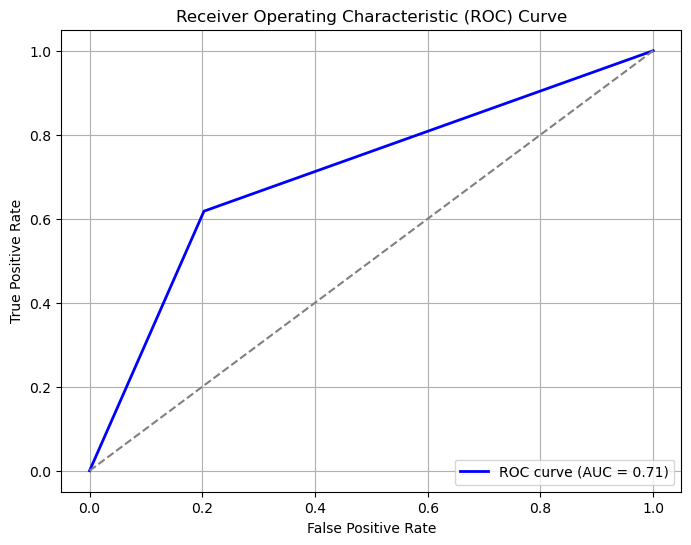

Model AUC: 0.708


In [38]:
pred = logistic_pca_optimal.predict(X_pca_optimal)
fpr, tpr, _ = roc_curve(y, pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"Model AUC: {roc_auc:.3f}")

---
---

# Advanced Statistical Learning: Conformal Inference

We will upgrade from linear methods from statistical learning theory to non-linear methods such as nerual network. Furthermore, we want to conduct `conformal inferences` to quantify the uncertainties that we see in our **blackbox** models.

### Fitting a Fully Connected Neural Network

We will fit just a fully connected neural network in this section with use of 3 layered network, **Cross Entropy Loss**, and a **Sigmoid** function as the last output head.

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import ipywidgets as widgets
from ipywidgets import interact

ModuleNotFoundError: No module named 'torch'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

input_dim = X.shape[1]
model = NeuralNet(input_dim)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

epochs = 250
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

Similarly, we will evaluate the AUC/ROC curve just as our previous model.

In [ ]:
with torch.no_grad():
    p_test = model(X_test_tensor).numpy().flatten()

fpr, tpr, _ = roc_curve(y_test, p_test)
auc_test = roc_auc_score(y_test, p_test)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"Neural Network (AUC = {auc_test:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")  # Baseline
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.show()


### Conformal Inference

We will follow the following conformal inference procedure:

> #### Define a heuristic (non)-conformity measure
>
> Define a (non)-conformity measure $s(y, x)$ which measures how well the prediction $\hat{y}_i$ fits the actual value $y_i$.
> 
> **Note:** this must take into account the nature of the model $f$, for example:
>
> Sicne $\mathcal{Y} = \{0,1\}$ and $f(x) = (p_0, p_1)$ is a Logistic Regression, then we would have the scoring function as the following:
>
>
> $$
> s(y, x) = y \log(p_1) + (1 - y) \log(p_0)
> $$

<br>

> #### Compute non-conformity scores and quantile
>
> For each $x_i$ in the calibration set, compute the **non-conformity score $s(y_i, \hat{y}_i)$** that quantifies how "unusual" the true label is relative to the model’s prediction, i.e.,
>
> $$
> s_i = s(y_i, \hat{y}_i) \quad \text{for} \quad (x_i, y_i) \in \mathcal{D}_{\text{cal}}
> $$
>
> For the **desired coverage** $\alpha$, to construct a confidence set, we must determine the threshold, which ensures that at least $1 - \alpha$ fraction of future predictions fall within this threshold. Then we just compute the $\lfloor (1 - \alpha) \cdot n_{\text{cal}} \rfloor / n_{\text{cal}}$-th quantile of the scores $\{s_i\}$, i.e.,
>
> $$
> \hat{q} = \text{quantile} \left( \frac{\lfloor (1 - \alpha) \cdot n_{\text{cal}} \rfloor}{n_{\text{cal}}} ; \{s_i\} \right)
> $$
>
> However, we will  be using an different version comparing to the standard version:
>
> $$
> \hat{q}(x) = \text{quantile} \left( \frac{\lfloor (1 - \alpha) \cdot n_{\text{cal}} \rfloor}{n_{\text{cal}}} ; \{s_i\} \right) + \lambda \cdot (0.5 - |p(x) - 0.5|)
> $$
>
> This is a more adaptive to uncertainty wheer we give **wider intervals for uncertain points (near 0.5 predicted proabbility)** since standard conformal inference assumes uniform uncertainty, which is not always true.
>

<br>

> #### Compute the Prediction Set
>
> Given $\hat{q}$ from step 5, the prediction set for a new observation $x$ is the ones that are beneath this quantile:
>
> $$
> \Gamma_{\alpha}(x) = \{ y \in \mathcal{Y} \mid s(y, \hat{f}(x)) \leq \hat{q} \}
> $$


In [ ]:
with torch.no_grad():
    p_train = model(X_train_tensor).numpy().flatten()
    p_test = model(X_test_tensor).numpy().flatten()

eps = 1e-8
nonconformity_scores = - (y_train * np.log(p_train + eps) + (1 - y_train) * np.log(1 - p_train + eps))

In [ ]:
def plot_conformal_intervals(alpha_base=0.1, lambda_factor=0.2):
    """
    Plots NN predictions with interactive adaptive conformal intervals.
    """
    # adaptive alpha based on uncertainty
    alpha_dynamic = alpha_base + lambda_factor * (0.5 - np.abs(p_test - 0.5))
    
    # conformal quantile for each sample
    q_alpha_dynamic = np.array([
        np.percentile(nonconformity_scores, (1 - alpha) * 100) for alpha in alpha_dynamic
    ])

    # conformal prediction intervals
    lower_bound = p_test - q_alpha_dynamic
    upper_bound = p_test + q_alpha_dynamic
    lower_bound = np.clip(lower_bound, 0, 1)
    upper_bound = np.clip(upper_bound, 0, 1)

    plt.figure(figsize=(8, 5))
    plt.scatter(range(len(p_test[:100])), p_test[:100], label="NN Predictions", color='blue', alpha=0.6)
    plt.fill_between(range(len(p_test[:100])), lower_bound[:100], upper_bound[:100], color='gray', alpha=0.3, label="Adaptive Conformal Interval")
    plt.xlabel("Sample Index")
    plt.ylabel("Predicted Probability")
    plt.title(f"NN Predictions with Adaptive Conformal Intervals\nBase Alpha: {alpha_base}, Lambda: {lambda_factor}")
    plt.legend()
    plt.show()

In [ ]:
interact(plot_conformal_intervals, 
         alpha_base=widgets.FloatSlider(min=0.01, max=0.5, step=0.01, value=0.1, description="Base Alpha"),
         lambda_factor=widgets.FloatSlider(min=0, max=0.5, step=0.01, value=0.2, description="Lambda Factor"))

In the same sense, we can check again with our pure logistic model and observe similar effects.

In [ ]:
logit_model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
p_train = logit_model.predict(sm.add_constant(X_train))
p_test = logit_model.predict(sm.add_constant(X_test))
eps = 1e-8
nonconformity_scores = - (y_train * np.log(p_train + eps) + (1 - y_train) * np.log(1 - p_train + eps))

In [ ]:
def plot_conformal_intervals(alpha_base=0.1, lambda_factor=0.2):
    """
    Plots logistic regression predictions with interactive adaptive conformal intervals.
    """
    alpha_dynamic = alpha_base + lambda_factor * (0.5 - np.abs(p_test - 0.5))
    
    q_alpha_dynamic = np.array([
        np.percentile(nonconformity_scores, (1 - alpha) * 100) for alpha in alpha_dynamic
    ])

    lower_bound = p_test - q_alpha_dynamic
    upper_bound = p_test + q_alpha_dynamic
    lower_bound = np.clip(lower_bound, 0, 1)
    upper_bound = np.clip(upper_bound, 0, 1)

    plt.figure(figsize=(8, 5))
    plt.scatter(range(len(p_test[:100])), p_test[:100], label="Logistic Predictions", color='blue', alpha=0.6)
    plt.fill_between(range(len(p_test[:100])), lower_bound[:100], upper_bound[:100], color='gray', alpha=0.3, label="Adaptive Conformal Interval")
    plt.xlabel("Sample Index")
    plt.ylabel("Predicted Probability")
    plt.title(f"Logistic Regression Predictions with Adaptive Conformal Intervals\nBase Alpha: {alpha}")
    plt.legend()
    plt.show()

In [ ]:
interact(plot_conformal_intervals, 
         alpha_base=widgets.FloatSlider(min=0.01, max=0.5, step=0.01, value=0.4, description="Base Alpha"),
         lambda_factor=widgets.FloatSlider(min=0, max=0.5, step=0.01, value=0.2, description="Lambda Factor"))

---